In [2]:
%load_ext autoreload
%autoreload 2
import pyBigWig, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import shutil
import seaborn as sns
import numpy as np
import util
import itertools
import metrics
import yaml
import wandb
# from test_to_bw_fast import * 
# import repl_analysis
from tqdm import tqdm
from test_to_bw_fast import get_config
import tfr_evaluate
from tfr_evaluate import get_true_pred, change_resolution, collect_datasets, collect_run_dirs, get_performance

In [3]:
bin_run = {}
for run_dir in collect_run_dirs('BASENJI_BIN_LOSS'):
    parameters = get_config(run_dir)
    if parameters['loss_fn']['value'] == 'poisson':
        
        bin_run[parameters['bin_size']['value']] = run_dir
        

wandb: Currently logged in as: toneyan (use `wandb login --relogin` to force relogin)


In [3]:
bin_run = {256: 'paper_runs/basenji/binloss_basenji/run-20210923_162932-56p3xy2p',
             1: 'paper_runs/basenji/binloss_basenji/run-20210922_044222-5ueie0zy',
             2048: 'paper_runs/basenji/binloss_basenji/run-20210920_085441-14shgpx1',
             1024: 'paper_runs/basenji/binloss_basenji/run-20210920_082433-1ka588yc',
             512: 'paper_runs/basenji/binloss_basenji/run-20210920_075434-wilgxp1a',
             128: 'paper_runs/basenji/binloss_basenji/run-20210920_034502-n8axwb3r',
             64: 'paper_runs/basenji/binloss_basenji/run-20210920_034501-7tftpu54',
             32: 'paper_runs/basenji/binloss_basenji/run-20210920_034449-8p51o3ho'}

In [6]:
# get datasets
testset, targets, target_dataset_idr = collect_datasets()

In [7]:
# get performance metrics for various evaluation bin sizes 
bin_sizes = [1, 32, 64, 128, 256, 512, 1024, 2048]

performance_per_resolution = []
for raw_bin_size in bin_run.keys():
    model, _ = tfr_evaluate.read_model(bin_run[raw_bin_size])
    all_true, all_pred = get_true_pred(model, raw_bin_size, testset)
    for eval_bin_size in bin_sizes:
        if eval_bin_size>=raw_bin_size:
            print(raw_bin_size, '--->', eval_bin_size)
            true_for_eval = change_resolution(all_true, raw_bin_size, eval_bin_size)
            pred_for_eval = change_resolution(all_pred, raw_bin_size, eval_bin_size)
            performance = get_performance(true_for_eval, pred_for_eval, targets, 'whole')
            performance_per_resolution.append([raw_bin_size, eval_bin_size] + list(performance.mean().values))



256 ---> 256
256 ---> 512
256 ---> 1024


/home/shush/tf_2/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


256 ---> 2048
1 ---> 1
1 ---> 32
1 ---> 64
1 ---> 128
1 ---> 256
1 ---> 512
1 ---> 1024
1 ---> 2048
2048 ---> 2048
1024 ---> 1024
1024 ---> 2048
512 ---> 512
512 ---> 1024
512 ---> 2048
128 ---> 128
128 ---> 256
128 ---> 512
128 ---> 1024
128 ---> 2048
64 ---> 64
64 ---> 128
64 ---> 256
64 ---> 512
64 ---> 1024
64 ---> 2048
32 ---> 32
32 ---> 64
32 ---> 128
32 ---> 256
32 ---> 512
32 ---> 1024
32 ---> 2048


In [8]:
metric_label = {'pr_corr':'Pearson r'}
metric = list(metric_label.keys())[0]
label = metric_label[metric]

In [9]:
sorted_personr = pd.DataFrame(performance_per_resolution, columns=['train', 'eval']+list(performance.columns[:-1].values)).sort_values(['train', 'eval'])[['train', 'eval', metric]]


In [11]:
sorted_personr.to_csv('sorted_'+label)

In [12]:
sorted_personr = pd.read_csv('sorted_'+label)

In [10]:
padded_values = []
bin_sizes = [1, 32, 64, 128, 256, 512, 1024, 2048]

for train_bin, df in sorted_personr.groupby('train'):
    pr_values = list(df[metric].values)
    add_N = len(bin_sizes)-len(pr_values)
    if add_N>0:
        pr_values = [np.nan for n in range(add_N)]+pr_values
    padded_values.append(pr_values)

Text(33.0, 0.5, 'Training bin size')

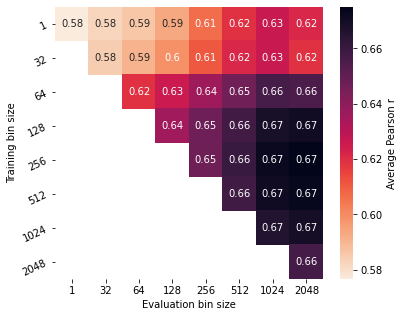

In [11]:
fig, ax = plt.subplots(figsize=[6, 5])
 
# creating mask
mask = np.triu(np.ones_like(padded_values), 1).T
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(padded_values, cmap="rocket_r", annot=True, mask=mask, 
                       cbar_kws={'label': "Average "+label}, ax=ax)
dataplot.set_xticks([r+0.5 for r in range(len(bin_sizes))]) 
dataplot.set_yticks([r+0.5 for r in range(len(bin_sizes))]) 
dataplot.set_xticklabels(bin_sizes) 
dataplot.set_yticklabels(bin_sizes, rotation=25) 
dataplot.set_xlabel('Evaluation bin size')
dataplot.set_ylabel('Training bin size')